# (Modified) cosine - Find similar compounds for unknown substances

### Here: Only consider annotated spectra to be sure there is no remaining spectra which belong to one of the selected Inchikeys to be removed...
One very important use case for a spectral similariy measure is libarary matching.  
This means matching previously unseen/unknown spectra to known, annotated sepctra in a larger library.
With spec2vec, however, it also becomes possible to search large datasets only based on Spec2Vec similarities. This allows to also find suggestions for compounds which are not in the library.

In [2]:
import os
import sys
import gensim
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

ROOT = os.path.dirname(os.getcwd())
#path_data = os.path.join(ROOT, 'data')
path_data = 'C:\\OneDrive - Netherlands eScience Center\\Project_Wageningen_iOMEGA\\matchms\\data\\'
sys.path.insert(0, ROOT)

### Import pre-processed dataset "AllPositive"
+ 112956 spectra with positive ionmode
+ 95320 of which with >= 10 peaks (only those will be used here!)

In [2]:
from matchms.importing import load_from_json

filename = os.path.join(path_data,'gnps_positive_ionmode_cleaned_by_matchms_and_lookups.json')
spectrums = load_from_json(filename)

print("number of spectra:", len(spectrums))

number of spectra: 112956


In [ ]:
# alternative (faster)
import pickle
outfile = os.path.join(path_data,'gnps_positive_ionmode_cleaned_by_matchms_and_lookups.pickle')
with open(outfile, 'rb') as file:
    spectrums = pickle.load(file)

### Post-process data
Run ``matchms`` based processing pipeline:
+ Normalize peaks
+ remove peaks outside [0, 1000.0] mz window
+ remove spectra with <10 peaks
+ remove low intensity peaks (< 0.01 from max intensity)

In [3]:
from matchms.filtering import normalize_intensities
from matchms.filtering import require_minimum_number_of_peaks
from matchms.filtering import select_by_mz
from matchms.filtering import select_by_relative_intensity

def post_process_classical(s):
    s = normalize_intensities(s)
    s = select_by_mz(s, mz_from=0, mz_to=1000)
    s = require_minimum_number_of_peaks(s, n_required=10)
    s = select_by_relative_intensity(s, intensity_from=0.01, intensity_to=1.0)
    return s

# apply filters to the data
spectrums_classical = [post_process_classical(s) for s in spectrums]

# omit spectrums that didn't qualify for analysis
spectrums_classical = [s for s in spectrums_classical if s is not None]

print("{} remaining spectra.".format(len(spectrums_classical)))

In [4]:
print("After processing {} spectra remain.".format(len(spectrums_s2v)))

After processing 95320 spectra remain.


In [3]:
import pickle
outfile = os.path.join(path_data,'gnps_positive_ionmode_processed_classical.pickle')
with open(outfile, 'rb') as file:
    spectrums_classical = pickle.load(file)

## Inspect annotations

In [6]:
Inchikeys = []
for spec in spectrums_classical:
    Inchikeys.append(spec.get("inchikey"))
    
print("Found {} spectra with Inchikey".format(len([x for x in Inchikeys if x])),
     "(out of {}).".format(len(spectrums_classical)))

Found 77092 spectra with Inchikey (out of 95320).


In [7]:
spectrum_idx_no_inchikey = [i for i, x in enumerate(Inchikeys) if not x]
print("Spectra without inchikey:", len(spectrum_idx_no_inchikey))

Spectra without inchikey: 18228


In [8]:
Inchikeys[:10]

['IYDKWWDUBYWQGF-NNAZGLEUSA-N',
 'KNGPFNUOXXLKCN-ZNCJFREWSA-N',
 'WXDBUBIFYCCNLE-NSCMQRKRSA-N',
 'CGZKSPLDUIRCIO-RPCRKUJJSA-N',
 '',
 'USXIYWCPCGVOKF-LERJCCFDSA-N',
 '',
 'WCNJVJCYRBJSLC-BCJYPDSRSA-N',
 'USXIYWCPCGVOKF-NOENWEJRSA-N',
 'WCNJVJCYRBJSLC-BCJYPDSRSA-N']

In [9]:
inchikeys_pd = pd.Series([x for x in Inchikeys])
inchikeys_pd.str[:14].value_counts()[:10]

                  18226
NEGQHKSYEYVFTD      432
SULIDBRAXVDKBU      426
IQGPMZRCLCCXAG      308
WTJKGGKOPKCXLL      295
IIZPXYDJLKNOIY      235
RWKUXQNLWDTSLO      234
QIBZFHLFHCIUOT      225
ZAYXPDDGEIJGGW      212
QJWDAOSZZYVBJZ      210
dtype: int64

In [10]:
inchikeys_notempty = inchikeys_pd[[i for i,x in enumerate(inchikeys_pd) if x]]
inchikeys_notempty.head()

0    IYDKWWDUBYWQGF-NNAZGLEUSA-N
1    KNGPFNUOXXLKCN-ZNCJFREWSA-N
2    WXDBUBIFYCCNLE-NSCMQRKRSA-N
3    CGZKSPLDUIRCIO-RPCRKUJJSA-N
5    USXIYWCPCGVOKF-LERJCCFDSA-N
dtype: object

Text(0.5, 1.0, 'Histogram of spectra per unique InchiKey (first 14 characters)')

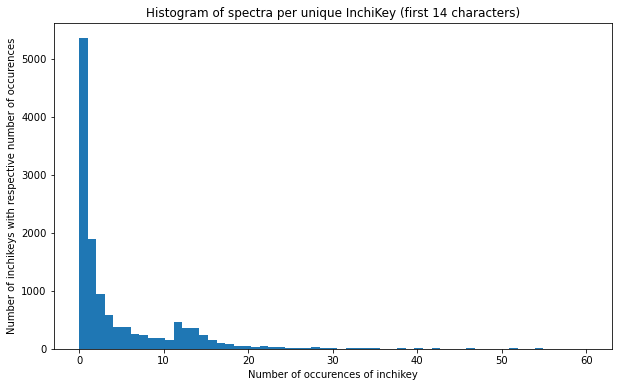

In [11]:
plt.figure(figsize=(10,6))
plt.hist(inchikeys_notempty.str[:14].value_counts(), np.linspace(0, 60, 60))
plt.xlabel('Number of occurences of inchikey')
plt.ylabel('Number of inchikeys with respective number of occurences')
plt.title("Histogram of spectra per unique InchiKey (first 14 characters)")

## Select query spectra (which will be removed from library)
+ Randomly select 200 InchiKeys
+ Select all spectra with those InchiKeys 

In [12]:
unique_inchikeys = inchikeys_notempty.str[:14].unique()
print("Found {} unique InchiKeys in the dataset (counting first 14 characters only)".format(unique_inchikeys.shape[0]))

Found 12846 unique InchiKeys in the dataset (counting first 14 characters only)


In [13]:
num_inchikeys = 200

np.random.seed(0) # to make it reproducible
selected_inchikeys = np.random.choice(unique_inchikeys, num_inchikeys, replace=False)
selected_inchikeys[:25]

array(['USEXQPWLCGBYNT', 'URAYPUMNDPQOKB', 'OGNSCSPNOLGXSM',
       'GNPWSZMDKPTDLE', 'VYFYYTLLBUKUHU', 'WDKPRHOCWKLQPK',
       'DMJNNHOOLUXYBV', 'CXOXHMZGEKVPMT', 'HTCVSLIHSFBUEL',
       'ROWKODQLOIEBHL', 'RJECHNNFRHZQKU', 'XIYSEKITPHTMJT',
       'ZDYHKOFGYRLNSW', 'GKHCBYYBLTXYEV', 'QPNFBUARICHXGG',
       'BECNNJLLIXQSGY', 'NOHZAMDNJBVHTA', 'DVLLGHPCJPEUHA',
       'CLNILJPYOXIKRO', 'BGLMHEUNVVQFLX', 'HBUBKKRHXORPQB',
       'UTZJMFNIKVHUDP', 'BWHHTYGQTQWLHV', 'MNKNQKOOKLVXDB',
       'DEJPAJWPCTUPPL'], dtype=object)

In [14]:
selected_spectra = []

for inchikey in selected_inchikeys:
    matches = inchikeys_notempty[inchikeys_notempty.str[:14] == inchikey].index.values
    selected_spectra.extend(matches)

print(len(selected_spectra), "spectra were found with Inchikeys from selected_inchikeys list.")

1030 spectra were found with Inchikeys from selected_inchikeys list.


### Check if that worked

In [16]:
ID = 0
inchikey = selected_inchikeys[0]
print(inchikey)

matches_test = inchikeys_pd[inchikeys_pd.str[:14] == inchikey].index.values

for idx in matches_test:
    print(spectrums_classical[idx].get("inchikey")[:14])

USEXQPWLCGBYNT
USEXQPWLCGBYNT
USEXQPWLCGBYNT


In [17]:
print(selected_spectra[:25])

[66105, 95146, 18446, 63328, 63329, 63330, 94926, 3117, 18524, 24773, 25253, 25709, 63340, 63341, 63342, 63343, 63344, 63731, 63732, 63733, 63734, 63735, 64942, 64943, 67682]


Text(0.5, 1.0, 'Histogram of spectra per unique InchiKey (first 14 characters)')

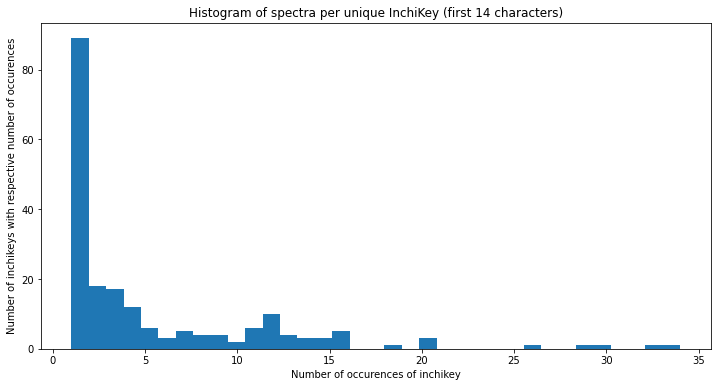

In [18]:
plt.figure(figsize=(12,6))
plt.hist(inchikeys_pd.str[:14][selected_spectra].value_counts(), 35)
plt.xlabel('Number of occurences of inchikey')
plt.ylabel('Number of inchikeys with respective number of occurences')
plt.title("Histogram of spectra per unique InchiKey (first 14 characters)")

In [19]:
selected_inchikey_counts = inchikeys_pd.str[:14][selected_spectra].value_counts()
print("Mean number of spectra per Inchikey:", np.mean(selected_inchikey_counts))
print("Median number of spectra per Inchikey:", np.median(selected_inchikey_counts))
print("Maximum number of spectra per Inchikey:", np.max(selected_inchikey_counts))

Mean number of spectra per Inchikey: 5.15
Median number of spectra per Inchikey: 2.0
Maximum number of spectra per Inchikey: 34


## Actual library matching
+ Import ``library_matching`` function
+ Load pre-trained model
+ Generate query documents
+ Query those documents against the library

In [20]:
sys.path.insert(0, os.path.join(ROOT, "custom_functions"))

In [21]:
from library_search import library_matching

### Correct a few (< 10) spectrums with missing precursor_mz

In [22]:
for i, spec in enumerate(spectrums_classical):
    if not spec.get("precursor_mz"):
        print(i)
        fix_mass = 0.0
        for history in spec.metadata['annotation_history']:
            fix_mass_test = float(history['Precursor_MZ'])
            fix_mass = max(fix_mass, fix_mass_test)
        charge = spec.get("charge")
        protons_mass = 1.00727645199076 * charge
        precursor_mass = fix_mass * abs(charge)
        parent_mass = precursor_mass - protons_mass
        if parent_mass:
            print("parent mass new:", parent_mass, "former was:", spec.get("parent_mass"))
            spec.set("parent_mass", parent_mass)
        print("precursor_mz new:", fix_mass, "former was:", spec.get("precursor_mz"))
        spec.set("precursor_mz", fix_mass)

2765
parent mass new: 547.2247235480093 former was: -1.00727645199076
precursor_mz new: 548.232 former was: 0.0
2766
parent mass new: 589.2357235480093 former was: -1.00727645199076
precursor_mz new: 590.243 former was: 0.0
3942
parent mass new: 466.2697235480092 former was: -1.00727645199076
precursor_mz new: 467.277 former was: 0.0
3974
parent mass new: 674.4887235480093 former was: -1.00727645199076
precursor_mz new: 675.496 former was: 0.0
3975
parent mass new: 691.5147235480093 former was: -1.00727645199076
precursor_mz new: 692.522 former was: 0.0
3976
parent mass new: 696.4707235480092 former was: -1.00727645199076
precursor_mz new: 697.478 former was: 0.0
3983
parent mass new: 629.6107235480093 former was: -1.00727645199076
precursor_mz new: 630.618 former was: 0.0
3984
parent mass new: 491.47072354800923 former was: -1.00727645199076
precursor_mz new: 492.478 former was: 0.0
3985
parent mass new: 531.4627235480093 former was: -1.00727645199076
precursor_mz new: 532.47 former w

### Run Spec2Vec and parentmass based library matching for 1030 against 94290 spectra
+ ``library_matching`` will return one pandas ``DataFrame`` for every query, which contains the selected best candidates, their IDs and scores.
+ The search will here be performed by calculating modified cosine scores for all possible pairs

In [24]:
from spec2vec import SpectrumDocument

In [25]:
documents_library = []
for i, spec in enumerate(spectrums_classical):
    if i not in selected_spectra and i not in spectrum_idx_no_inchikey:
        documents_library.append(SpectrumDocument(spec, n_decimals=2))

In [26]:
# Check
library_inchikeys = []
for doc in documents_library:
    library_inchikeys.append(doc._obj.get("inchikey"))
    
print("Found {} spectra with Inchikey".format(len([x for x in library_inchikeys if x])),
     "(out of {} library spectra).".format(len(documents_library)))

Found 76062 spectra with Inchikey (out of 76062 library spectra).


In [28]:
documents_query = [SpectrumDocument(spectrums_classical[i], n_decimals=2) for i in selected_spectra]
print(len(spectrums_classical), len(documents_library), len(documents_query))

95320 76062 1030


In [88]:
import time

tstart = time.time()
found_matches = library_matching(documents_query, documents_library,
                                 model=None,
                                 presearch_based_on=["modcos-top20"],
                                 ignore_non_annotated=True,
                                 include_scores=["cosine"],
                                 intensity_weighting_power=0.5,
                                 cosine_tol=0.005,
                                 min_matches=6,
                                 mass_tolerance=1.0,
                                 mass_tolerance_type="ppm")

tend = time.time()
print("Execution time was {:.2f}s (library search of {} query spectra against {} library spectra).".format((tend-tstart),
                                                                                                       len(documents_query),
                                                                                                       len(documents_library)))

  0%|                                                                              | 1/76062 [00:00<2:25:52,  8.69it/s]

Pre-selection includes modified cosine top 20.


100%|██████████████████████████████████████████████████████████████████████████| 76062/76062 [2:45:43<00:00,  7.65it/s]


(76062, 1030) (76062, 1030)


  1%|▊                                                                              | 11/1030 [00:00<00:09, 108.97it/s]

Calculate cosine score for selected candidates.


100%|█████████████████████████████████████████████████████████████████████████████| 1030/1030 [00:07<00:00, 130.27it/s]


Execution time was 9955.37s (library search of 1030 query spectra against 76062 library spectra).


In [93]:
found_matches[4]

,cosine_score,cosine_matches,mod_cosine_score,mod_cosine_matches
45023,0.309409,5,0.311193,6.0
45378,0.149754,5,0.152357,6.0
45379,0.060791,3,0.083395,6.0
71374,0.013213,7,0.013661,8.0
71443,0.006724,9,0.014825,10.0
71474,0.005770,8,0.014343,11.0
71516,0.003450,9,0.012101,9.0
71563,0.007163,9,0.073885,10.0
71569,0.007306,8,0.015578,9.0
71640,0.009249,13,0.012119,13.0


In [94]:
# Check number of queries done
len(found_matches)

1030

### Inspect tables with found matches

In [95]:
found_matches[104].sort_values(by=["mod_cosine_score"], ascending=False)

,cosine_score,cosine_matches,mod_cosine_score,mod_cosine_matches
11848,0.986116,8,0.986116,8.0
10469,0.985215,10,0.985215,10.0
11847,0.982901,7,0.982901,7.0
8570,0.982000,7,0.982000,7.0
11250,0.980545,8,0.980545,8.0
11644,0.978219,10,0.978219,10.0
7506,0.977123,6,0.977123,6.0
10948,0.976428,7,0.976428,7.0
11665,0.976180,7,0.976180,7.0
9884,0.976101,6,0.976101,6.0


# Evaluate results
## Collect all top-10 matches based on ModifiedCosine similarity
+ Select top-10 modified cosine score matches for every query
+ Get fingerprint-based reference scores for those suggested matches

Define get_mol_fingerprints function.

In [96]:
from matchms.utils import derive_fingerprint_from_inchi
from matchms.utils import derive_fingerprint_from_smiles

def get_mol_fingerprints(spectrums, fingerprint_type="daylight", nbits=2048):
    """Return molecular finterprints.
    """
    def _get_fingerprint_from_spectrum(spectrum):
        # First try to get fingerprint from smiles
        if spectrum is None:
            return None
        if spectrum.get("smiles", None):
            fingerprint = derive_fingerprint_from_smiles(spectrum.get("smiles"),
                                                         fingerprint_type, nbits)
            if isinstance(fingerprint, np.ndarray) and fingerprint.sum() > 0:
                return fingerprint

        # Second try to get fingerprint from inchi
        if spectrum.get("inchi", None):
            fingerprint = derive_fingerprint_from_inchi(spectrum.get("inchi"),
                                                        fingerprint_type, nbits)
            if isinstance(fingerprint, np.ndarray) and fingerprint.sum() > 0:
                return fingerprint  
        
    fingerprints = []
    for spec in spectrums:
        fingerprint = _get_fingerprint_from_spectrum(spec)
        fingerprints.append(fingerprint)
    
    return fingerprints

In [98]:
from matchms.similarity.vector_similarity_functions import jaccard_similarity_matrix

mol_sim_matches = []
list_cosine = []
list_modcos = []
top_n = 10

for ID in range(len(documents_query)):
    idx = found_matches[ID].sort_values(by=["mod_cosine_score"], ascending=False).index.tolist()[:top_n]
    
    if len(idx) > 0:
        fingerprint_query = get_mol_fingerprints([documents_query[ID]._obj], 
                                                     fingerprint_type="daylight", #morgan3", 
                                                     nbits=2048)
        fingerprint_matches = get_mol_fingerprints([documents_library[i]._obj for i in idx], 
                                                     fingerprint_type="daylight", #morgan3",  
                                                     nbits=2048)

        # Calculate similarities
        if fingerprint_query[0] is None:
            print("No fingerprint generated for query spectrum {}".format(ID))
        else:
            if np.sum([1 for x in fingerprint_matches if x is None]) > 0:
                print("Found {} not generated fingerprints in matches".format(np.sum([1 for x in fingerprint_matches if x is None])))
            exclude_empty_fps = [i for i, x in enumerate(fingerprint_matches) if x is not None]
            if len(fingerprint_matches) > 0 and len(fingerprint_query) > 0:
                Mtest = jaccard_similarity_matrix(np.asarray(fingerprint_query),
                                                   np.asarray([fingerprint_matches[i] for i in exclude_empty_fps]))
                mol_sim_matches.append(Mtest)
            else:
                mol_sim_matches.append(None)

            list_cosine.append(found_matches[ID].loc[[idx[i] for i in exclude_empty_fps]]['cosine_score'].values.tolist())
            list_modcos.append(found_matches[ID].loc[[idx[i] for i in exclude_empty_fps]]['mod_cosine_score'].values.tolist())

#### Define a histogram plotting function

In [99]:
def histogram_found_matches(matches,
                            n_bins,
                            method = "ideal_pick",
                            sort_by_lst = None):
    """ Create histogram and plot it.
    """
    bins_lst = np.linspace(0,1,n_bins+1) 
    plt.style.use('default') #('ggplot')
    plt.figure(figsize=(8,7))
    
    nums = len(matches)
    if method == "ideal_pick": 
        # Chose best pick from condidate suggestions
        #hist, bin_edges = np.histogram(np.max(matches, axis=2), bins_lst)
        pick = []
        for i in range(nums):
            pick += [np.array(matches[i]).argmax()]
        hist, bin_edges = np.histogram(np.array([matches[i][0][pick[i]] for i in range(nums)]), bins_lst)
    elif method == 'argmax':
        if sort_by_lst is None:
            print("sort_by_lst list expected.")
        pick = []
        for i in range(nums):
            pick += [np.array(sort_by_lst[i]).argmax()]
        hist, bin_edges = np.histogram(np.array([matches[i][0][pick[i]] for i in range(nums)]), bins_lst)
    
    bar_width = 0.8 * 1/n_bins
    plt.bar(bin_edges[:-1], 100*hist/np.sum(hist), width = bar_width, color='none', edgecolor='gray', hatch="///", lw=2., zorder = 0)
    plt.bar(bin_edges[:-1], 100*hist/np.sum(hist), width = bar_width, edgecolor='black', linewidth=3, color='none',alpha=1)
    #plt.xlabel('best found molecular similarity among Spec2Vec top-10 suggestions \n (rdkit-2048 fingerprint --> jaccard score)')
    maxbar = np.max(100*hist/np.sum(hist))
    plt.yticks(10*np.arange(np.ceil(maxbar/10)), ["{}".format(10*x) for x in np.arange(np.ceil(maxbar/10))], fontsize=12)
    
    bar_labels = ['{:03.1f} - {:03.1f}'.format(bins_lst[i], bins_lst[i+1]) for i in range(n_bins)]
    plt.xticks(bins_lst[:-1], bar_labels, fontsize=12, rotation='vertical')
    plt.xlabel('molecular similarity (Tanimoto)', fontsize=16)
    plt.ylabel('fraction of matches [%]', fontsize=16)
        
    return hist, bin_edges

[231 271 163  91 274]


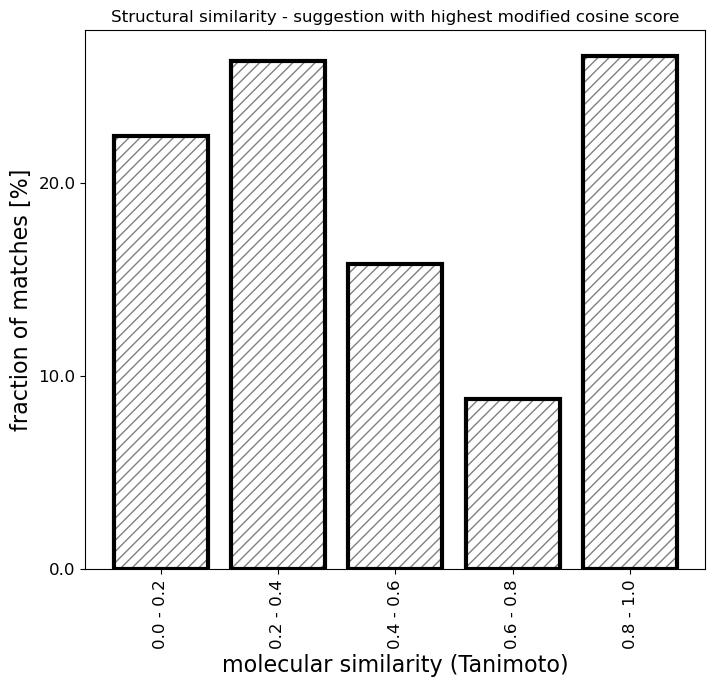

In [100]:
hist, bin_edges = histogram_found_matches(mol_sim_matches, 5, 'argmax', list_modcos)

print(hist)
plt.title("Structural similarity - suggestion with highest modified cosine score")
plt.savefig("Unknown_compound_matching_annotated_modcos_highest_score.pdf", bbox_inches='tight')

[116 180 223 131 380]


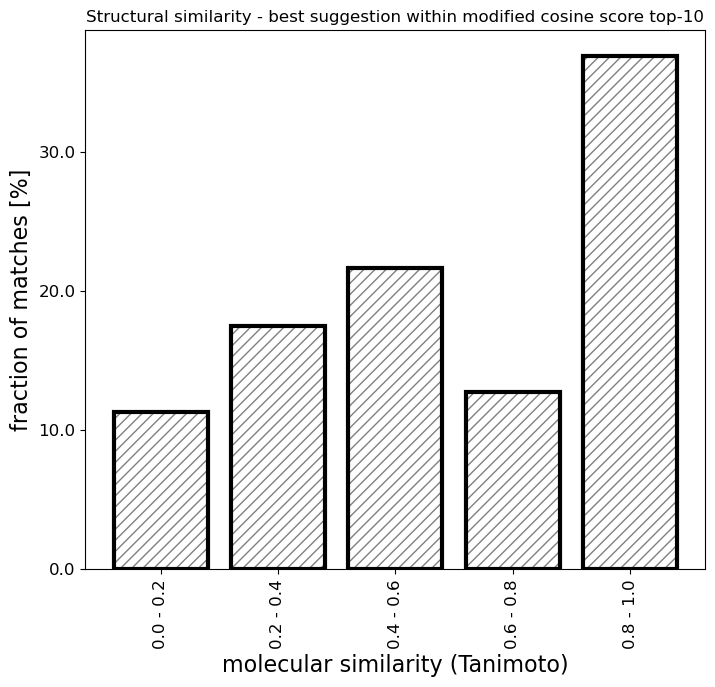

In [101]:
hist, bin_edges = histogram_found_matches(mol_sim_matches, 5, 'ideal_pick', list_modcos)

print(hist)
plt.title("Structural similarity - best suggestion within modified cosine score top-10")
plt.savefig("Unknown_compound_matching_annotated_modcos_ideal_pick.pdf", bbox_inches='tight')
plt.savefig("Unknown_compound_matching_annotated_modcos_ideal_pick.png", bbox_inches='tight')

[231 271 163  91 274]


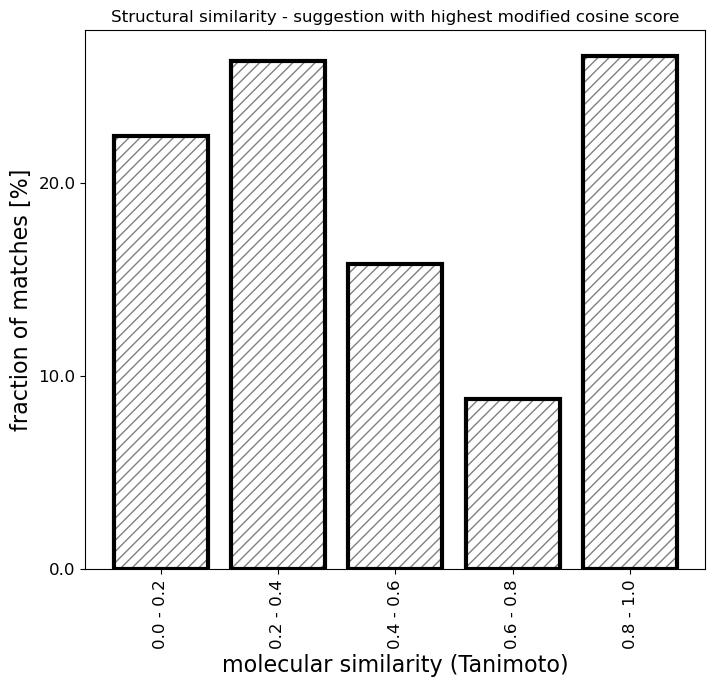

In [126]:
hist, bin_edges = histogram_found_matches(mol_sim_matches, 5, 'argmax', list_modcos)

print(hist)
plt.title("Structural similarity - suggestion with highest modified cosine score")
plt.savefig("Unknown_compound_matching_modcos_highest_score.pdf", bbox_inches='tight')
plt.savefig("Unknown_compound_matching_modcos_highest_score.svg", bbox_inches='tight')

[116 180 223 131 380]


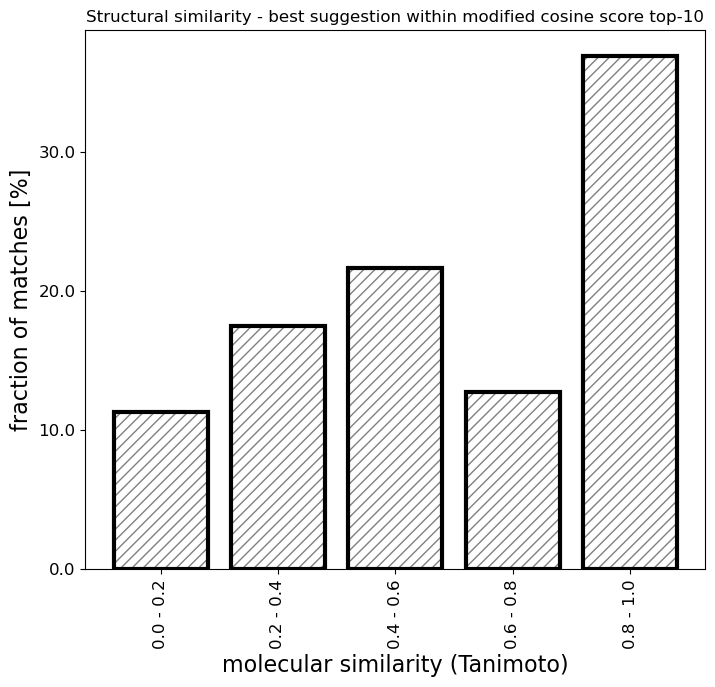

In [103]:
hist, bin_edges = histogram_found_matches(mol_sim_matches, 5, 'ideal_pick', list_modcos)

print(hist)
plt.title("Structural similarity - best suggestion within modified cosine score top-10")
plt.savefig("Unknown_compound_matching_modcos_ideal_pick.pdf", bbox_inches='tight')
plt.savefig("Unknown_compound_matching_modcos_ideal_pick.png", bbox_inches='tight')

# Compare compound mass vs match with structural similarity

Text(0, 0.5, 'structural similarity')

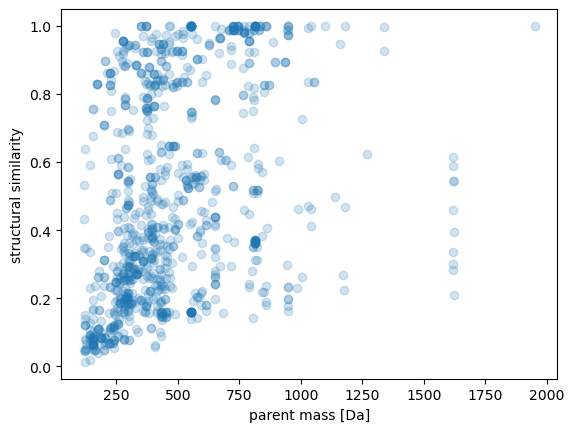

In [105]:
plt.scatter(np.asarray(masses), np.asarray([x[0][0] for x in mol_sim_matches]), alpha=0.2)
plt.xlabel("parent mass [Da]")
plt.ylabel("structural similarity")

In [107]:
mass_vs_similarity = pd.DataFrame(list(zip(masses,
                                           [x[0][0] for x in mol_sim_matches],
                                           [max(x[0]) for x in mol_sim_matches]
                                          )),
                                  columns=["parentmass", "tanimoto", "tanimoto_best_of_10"])

In [108]:
mass_bins = [0, 200, 400, 600, 800, 2000]
mass_bins_labels = ['{} - {}'.format(mass_bins[i], mass_bins[i+1]) for i in range(5)]
mass_vs_similarity["mass_bins"] = pd.cut(mass_vs_similarity["parentmass"], mass_bins, labels = mass_bins_labels)

In [123]:
mass_bins_labels

['0 - 200', '200 - 400', '400 - 600', '600 - 800', '800 - 2000']

In [124]:
mass_vs_similarity.head(20)

,parentmass,tanimoto,tanimoto_best_of_10,mass_bins
0,198.999724,0.049296,0.053309,0 - 200
1,198.999724,0.049296,0.053309,0 - 200
2,235.072724,0.119488,0.186957,200 - 400
3,117.992724,0.048563,0.070547,0 - 200
4,117.992724,0.431818,0.475000,0 - 200
5,117.992724,0.347458,0.347458,0 - 200
6,118.074724,0.532710,0.532710,0 - 200
7,1160.752724,0.947723,1.000000,800 - 2000
8,153.082724,0.081712,0.455172,0 - 200
9,153.082724,0.063158,0.064460,0 - 200


In [110]:
mass_vs_similarity.to_csv("unknown_matching_parentmass_vs_modcos.csv")

## Plot highest scoring mod.cosine per query in dependence of parentmass

In [106]:
import seaborn as sns

sns.set(style="ticks")

# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=(7, 6))

# Plot the orbital period with horizontal boxes
sns.boxplot(x="mass_bins", y="tanimoto", data=mass_vs_similarity,
            order=['0 - 200', '200 - 400', '400 - 600', '600 - 800', '800 - 2000'], palette="vlag_r")

# Add in points to show each observation
sns.swarmplot(x="mass_bins", y="tanimoto", data=mass_vs_similarity,
              order=['0 - 200', '200 - 400', '400 - 600', '600 - 800', '800 - 2000'],
              size=2, color=".3", linewidth=0)

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.yaxis.grid(True)
ax.set(ylabel="Structual simlarity (Tanimoto)")
ax.set(xlabel="Parent mass range [Da]")
sns.despine(trim=True, left=True)

plt.savefig("Unknown_compound_matching_annotated_mass_dependence_highest_modcos.pdf")
plt.savefig("Unknown_compound_matching_annotated_mass_dependence_highest_modcos.svg")

ModuleNotFoundError: No module named 'seaborn'

## Plot best pick out of top-10 s2v matches per query in dependence of parentmass

In [125]:
sns.set(style="ticks")

# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=(7, 6))

# Plot the orbital period with horizontal boxes
sns.boxplot(x="mass_bins", y="tanimoto_best_of_10", data=mass_vs_similarity,
            order=['0 - 200', '200 - 400', '400 - 600', '600 - 800', '800 - 2000'], palette="vlag_r")

# Add in points to show each observation
sns.swarmplot(x="mass_bins", y="tanimoto_best_of_10", data=mass_vs_similarity,
              order=['0 - 200', '200 - 400', '400 - 600', '600 - 800', '800 - 2000'],
              size=2, color=".3", linewidth=0)

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.yaxis.grid(True)
ax.set(ylabel="Structual simlarity (Tanimoto, best of of top 10)")
ax.set(xlabel="Parent mass range [Da]")
sns.despine(trim=True, left=True)

plt.savefig("Unknown_compound_matching_annotated_mass_dependence_modcos_best_of_10.pdf")
plt.savefig("Unknown_compound_matching_annotated_mass_dependence_modcos_best_of_10.svg")

NameError: name 'sns' is not defined

## Next steps... e.g. add thresholding...

In [118]:
found_matches[10].sort_values(by=["mod_cosine_score"], ascending=False)["mod_cosine_score"].values[0]

0.9843457929234191

In [120]:
mod_cosine_thres = 0.5
IDs_above_thres = []
for ID in range(len(documents_query)):
    top_score = found_matches[ID].sort_values(by=["mod_cosine_score"],
                                              ascending=False)["mod_cosine_score"].values[0]
    if top_score > mod_cosine_thres:
        IDs_above_thres.append(ID)

print(len(IDs_above_thres))

765
